In [1]:
import os
import functools
import operator
import gzip
import struct
import array
import numpy as np
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import os
from random import sample

def show_images(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_sample_grid(data, size_x, size_y):
    f, axarr = plt.subplots(size_x,size_y)
    for x in range(size_x):
        for y in range(size_y):
            index = np.random.randint(len(data))
            image = data[index]
            axarr[x,y].imshow(image.reshape(28,28), cmap='gray_r')
    
def fopen(filepath, options = 'rb'):

    DATA_TYPES = {
        0x08: 'B',  # unsigned byte
        0x09: 'b',  # signed byte
        0x0b: 'h',  # short (2 bytes)
        0x0c: 'i',  # int (4 bytes)
        0x0d: 'f',  # float (4 bytes)
        0x0e: 'd'   # double (8 bytes)
    }  

    __fopen = open

    if os.path.splitext(filepath)[1] == '.gz':
        __fopen = gzip.open

    with __fopen(filepath, options) as fd:
        header = fd.read(4)
        zeros, data_type, num_dimensions = struct.unpack('>HBB', header)

        data_type = DATA_TYPES[data_type]

        dimension_sizes = struct.unpack('>' + 'I' * num_dimensions,
                                        fd.read(4 * num_dimensions))
        data = array.array(data_type, fd.read())
        data.byteswap()
        expected_items = functools.reduce(operator.mul, dimension_sizes)

        return np.array(data).reshape(dimension_sizes)

def load_data_set(images_file_path, labels_file_path):
    return fopen(images_file_path), fopen(labels_file_path)

def pshape(var, name):
    print("{}.shape = {}".format(name, var.shape))

In [2]:
train_x, train_y = load_data_set('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test_x,  test_y  = load_data_set('t10k-images-idx3-ubyte.gz',  't10k-labels-idx1-ubyte.gz')

In [3]:
print('Размер тренировочных данных: x={}, y={}'.format(train_x.shape, train_y.shape))
print('Размер тестовых данных:  x={}, y={}'.format(test_x.shape, test_y.shape))

Размер тренировочных данных: x=(60000, 28, 28), y=(60000,)
Размер тестовых данных:  x=(10000, 28, 28), y=(10000,)


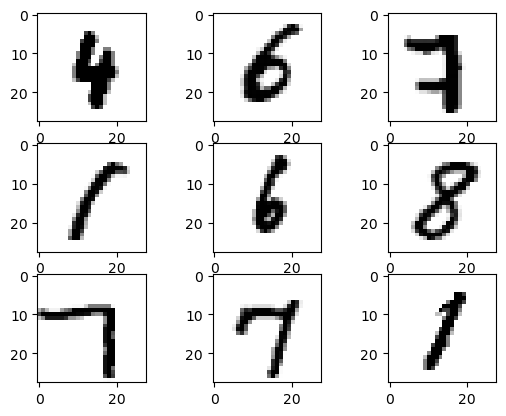

In [4]:
show_sample_grid(train_x, 3, 3)

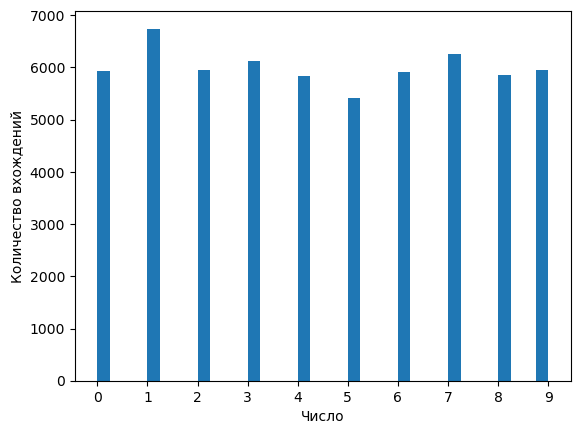

In [5]:
bins = list(set(train_y))
fig, ax = plt.subplots()

ax.hist(train_y, 'auto', align='mid')
ax.set_xticks(bins)

plt.xlabel("Число")
plt.ylabel("Количество вхождений")

plt.show()

Как можно видеть на данной гистограмме отображено количество всевозможных рукописных цифр, представленных в датасете. Для нас важно увидеть, что распределение в среднем равномерно. Представлены цифры от 0 до 9.

### Преобразуем данные

Перед тем как выполнить преобразование данных, определим некоторые величины. Зафиксируем количество представленных в датасете цифр, максимальмальную и минимальную яркость пикселей:

In [6]:
labels_size = len(set(train_y)); print('Количество цифр в датасете:', labels_size)

Количество цифр в датасете: 10


In [7]:
min_color_value = train_x.min(); print('Минимальная яркость:', min_color_value)
max_color_value = train_x.max(); print('Максимальная яркость:', max_color_value)

Минимальная яркость: 0
Максимальная яркость: 255


Выполним преобразование двумерных матриц яркостей пикселей в вектор. Нормализуем данные. Выполним бинаризацию признаков labels:

In [8]:
length, width, height = train_x.shape
train_x = (train_x.reshape(length, width * height) - min_color_value) / max_color_value.astype('float32')
train_y = np.eye(labels_size)[train_y]

print('Размер тренировочных данных: x={}, y={}'.format(train_x.shape, train_y.shape))

Размер тренировочных данных: x=(60000, 784), y=(60000, 10)


In [9]:
length, width, height = test_x.shape
test_x = (test_x.reshape(length, width * height) - min_color_value) / max_color_value.astype('float32')
test_y = np.eye(labels_size)[test_y]
    
print('Размер тестовых данных: x={}, y={}'.format(test_x.shape, test_y.shape))

Размер тестовых данных: x=(10000, 784), y=(10000, 10)


In [10]:
def relu(x):
    xx = x.copy()
    
    for i in range(len(xx)):
        for j in range(len(xx[i])):
            xx[i][j] = max(0, xx[i][j])
            
    return xx

def derivative_relu(x):
    xx = x.copy()
    for i in range(len(xx)):
        for j in range(len(xx[i])):            
            xx[i][j] = float(xx[i][j] > 0)

    return xx

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)